# Semantic Segmentation: Amazon forest satellite photographs, versus non-forest


Semantic segmentation, or sometimes just image segmentation, is the task of labelling every pixel in an image according to what type of object is depicted at that pixel. Some applications:

* Detecting foreground and background in photographs
* Detecting different materials in x-rays or other medical images
* Land-use in satellite imagery

In this notebook we will look at the last of these. In particular, we will use a dataset containing satellite images of the Amazon. They are annotated with per-pixel labels showing which areas are forest and which are non-forest.

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np

In [5]:
from tensorflow import keras
from keras import layers

The dataset is described at:

https://zenodo.org/record/3233081#.Y_8qYC-nyfA

and available for download (about 20Mb):

https://zenodo.org/record/3233081/files/Amazon%20Forest%20Dataset.rar?download=1

It is in `rar` format. If you have `unrar` you can download it from there and run `unrar`. BTW, Google Colab has `unrar`.

In case you don't have `unrar`, I provide a `zip` version in Canvas. Download it from there and run `unzip`.

In [3]:
# if it is your first time running, and you do have rar, uncomment these lines
#!curl -o "Amazon Forest Dataset.rar" https://zenodo.org/record/3233081/files/Amazon%20Forest%20Dataset.rar?download=1

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20.7M  100 20.7M    0     0   477k      0  0:00:44  0:00:44 --:--:--  517k


In [4]:
#!unrar x "Amazon Forest Dataset.rar"


UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from Amazon Forest Dataset.rar

Creating    Amazon Forest Dataset                                     OK
Creating    Amazon Forest Dataset/Test                                OK
Extracting  Amazon Forest Dataset/Test/0.tiff                              1%  OK 
Extracting  Amazon Forest Dataset/Test/1.tiff                              2%  OK 
Extracting  Amazon Forest Dataset/Test/10.tiff                             4%  OK 
Extracting  Amazon Forest Dataset/Test/11.tiff                             5%  OK 
Extracting  Amazon Forest Dataset/Test/12.tiff                             7%  OK 
Extracting  Amazon Forest Dataset/Test/13.tiff                             9%  OK 
Extracting  Amazon Forest Dataset/Test/14.tiff                            10%  OK 
Extracting  Amazon Forest Dataset/Test/2.tiff                             12%  OK 

In [3]:
# if it is your first time running, and you don't have rar, 
# download the zip from Canvas and uncomment this line:
!unzip "Amazon Forest Dataset.zip"

^C


After that, you will have a new directory `Amazon Forest Dataset`. We'll now walk the files and create our dataset in Numpy format.

In [6]:
def create_XY(d):
    # walk a directory (Training or Validation) and its subdirs images and masks,
    # and create X and Y
    Xs, Ys = [], []
    for filename in os.listdir(os.path.join(d, "images")):
        X = Image.open(os.path.join(d, "images", filename))
        # the mask (ie annotation) has the same filename, but under masks/ 
        # and replace .tiff with .png
        Y = Image.open(os.path.join(d, "masks", filename[:-5]+".png"))
        X = np.array(X, dtype=float) / 255.0 # normalise to [0, 1]
        Y = np.array(Y)[:512, :512] # discard some pixels from the one weird image which is 512x515
        Y = Y - 1 # values were 1 (forest) and 2 (non-forest), now 0 and 1
        Y = 1 - Y # now 0 (non-forest) and 1 (forest)
        Xs.append(X)
        Ys.append(Y)
    return np.array(Xs), np.array(Ys)

In [7]:
Xtrain, Ytrain = create_XY("Amazon Forest Dataset/Training")
Xval, Yval = create_XY("Amazon Forest Dataset/Validation")
# The test directory contains images only, no masks, so we'll ignore it
# Xtest, Ytest = create_XY("Amazon Forest Dataset/Testing")
print("shapes", Xtrain.shape, Ytrain.shape, Xval.shape, Yval.shape)
print("X min, max after normalisation", Xtrain.min(), Xtrain.max())
print("unique Y pixel values", np.unique(Ytrain))

shapes (30, 512, 512, 3) (30, 512, 512) (15, 512, 512, 3) (15, 512, 512)
X min, max after normalisation 0.054901960784313725 1.0
unique Y pixel values [0 1]


We'll define a handy function to show X, Y, and optionally Yhat.

In [8]:
def show(X, Y, Yhat=None):
    if Yhat is None:
        ncols = 2
    else:
        ncols = 3
    fig, axs = plt.subplots(ncols=ncols, figsize=(8, 8))
    axs[0].imshow(X)
    axs[0].axis('off')
    axs[1].imshow(Y)
    axs[1].axis('off')
    if Yhat is not None:
        axs[2].imshow(Yhat)
        axs[2].axis('off')

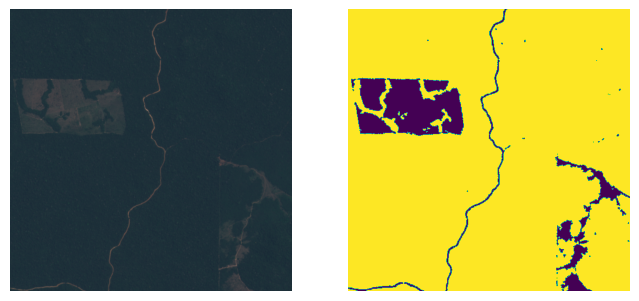

In [9]:
show(Xtrain[0, :, :, :], Ytrain[0, :, :]) # show the first pair from train set

In [10]:
num_classes = len(set(np.unique(Ytrain)))
num_classes

2

In [11]:
img_size = Xtrain[0].shape[0:2]
img_size

(512, 512)

Now we'll define an NN model for segmentation. This is going to be extremely simple! All we really need is a few conv layers. The output layer is a conv layer - an arrangement we haven't seen before! The output is thus an "image". 

We want that image to match the annotation mask Y. The masks are the same size as the input images X, so we configure our conv layers to output the same shape as the input. 

The network is fully-convolutional, so after training it could run on images of any size.

In our model below, the inputs and outputs are copied from a Keras U-net example (later in the notebook).


In [12]:
def get_simple_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,)) # from keras.io, see below
    
    x = inputs
    for i in range(3):
        x = layers.Conv2D(20, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.Dropout(0.05)(x)

    # Add a per-pixel classification layer
    # The number of channels is num_classes, with softmax
    # so eg channel 0 tells us the probability that each pixel is non-forest
    # softmax runs on axis -1 (the last dimension of the shape) by default
    # which means each pair of corresponding pixels in the output sums to 1.

    # from keras.io, see below
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

simple_model = get_simple_model(img_size, num_classes)
simple_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ input_layer (InputLayer)           │ (None, 512, 512, 3)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv2d (Conv2D)                    │ (None, 512, 512, 20)          │         560 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ batch_normalization                │ (None, 512, 512, 20)          │          80 │
│ (BatchNormalization)               │                               │             │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ activation (Activation)            │ (None, 512, 512, 20)          │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout (Dropout)                  │ (None, 512, 512, 20)          │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv2d_1 (Conv2D)                  │ (None, 512, 512, 20)          │       3,620 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ batch_normalization_1              │ (None, 512, 512, 20)          │          80 │
│ (BatchNormalization)               │                               │             │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ activation_1 (Activation)          │ (None, 512, 512, 20)          │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout_1 (Dropout)                │ (None, 512, 512, 20)          │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv2d_2 (Conv2D)                  │ (None, 512, 512, 20)          │       3,620 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ batch_normalization_2              │ (None, 512, 512, 20)          │          80 │
│ (BatchNormalization)               │                               │             │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ activation_2 (Activation)          │ (None, 512, 512, 20)          │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout_2 (Dropout)                │ (None, 512, 512, 20)          │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv2d_3 (Conv2D)                  │ (None, 512, 512, 2)           │         362 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 8,402 (32.82 KB)

 Trainable params: 8,282 (32.35 KB)

 Non-trainable params: 120 (480.00 B)

In [13]:
# sparse categorical crossentropy compares the ground-truth integer y value 
# (at a pixel) to the softmax probabilities from the model (at that pixel).
simple_model.compile(optimizer="rmsprop", 
                     metrics=["accuracy"],
                     loss="sparse_categorical_crossentropy")

In [28]:
# training for 10 epochs took a few minutes on a Mac desktop (no GPU)
# or a few seconds on Google Colab

# we probably want to see accuracy > 0.9 for reasonable performance

# a validation accuracy of 0.5222 seems to be the result we get when the 
# network predicts "non-forest" for every pixel

# training for 10 epochs is enough - sometimes! in some runs, we get unlucky

# if we see val loss is still high after 10 epochs, just re-execute this cell
# to continue training from where we were; or re-create the model, re-compile 
# and re-run training to start over.
# either could work.

epochs = 10
simple_model.fit(Xtrain, Ytrain, epochs=epochs, validation_data=(Xval, Yval))

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.1787 - accuracy: 0.9412 - val_loss: 0.6575 - val_accuracy: 0.8661
Epoch 2/10
1/1 [==============================] - 1s 946ms/step - loss: 0.1738 - accuracy: 0.9421 - val_loss: 0.6546 - val_accuracy: 0.8926
Epoch 3/10
1/1 [==============================] - 1s 921ms/step - loss: 0.1695 - accuracy: 0.9429 - val_loss: 0.6505 - val_accuracy: 0.8986
Epoch 4/10
1/1 [==============================] - 1s 917ms/step - loss: 0.1660 - accuracy: 0.9437 - val_loss: 0.6474 - val_accuracy: 0.8974
Epoch 5/10
1/1 [==============================] - 1s 921ms/step - loss: 0.1628 - accuracy: 0.9442 - val_loss: 0.6421 - val_accuracy: 0.9008
Epoch 6/10
1/1 [==============================] - 1s 942ms/step - loss: 0.1600 - accuracy: 0.9450 - val_loss: 0.6412 - val_accuracy: 0.9091
Epoch 7/10
1/1 [==============================] - 1s 918ms/step - loss: 0.1578 - accuracy: 0.9449 - val_loss: 0.6318 - val_accuracy: 0.9097
Epoch 8/10
1/1 [=======

# Visualisations

Now we'll take a look at the predictions made by the model on the validation set.

First we run the entire validation set.

In [29]:
Yhat_val = simple_model.predict(Xval)

1/1 [==============================] - 0s 155ms/step


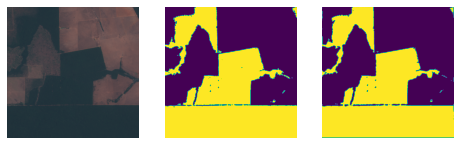

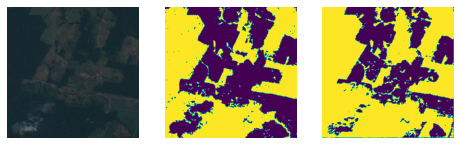

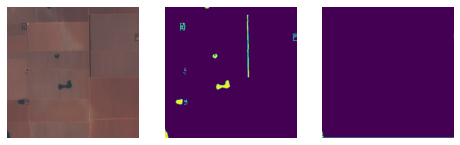

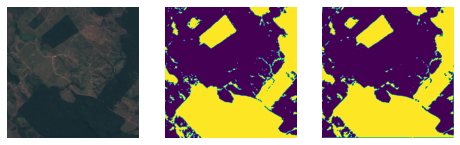

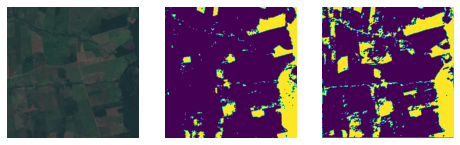

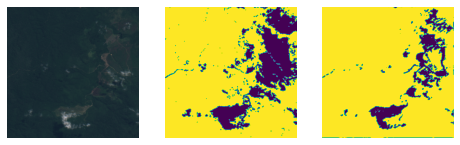

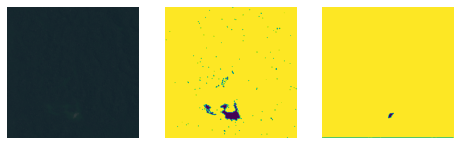

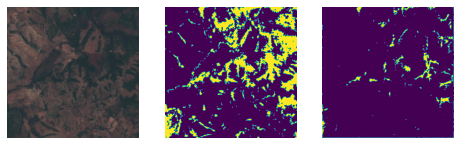

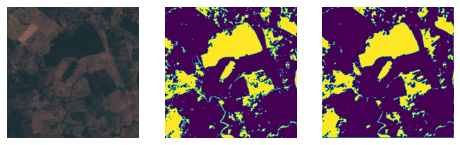

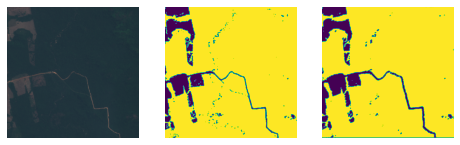

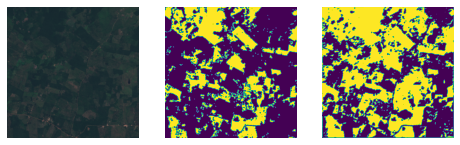

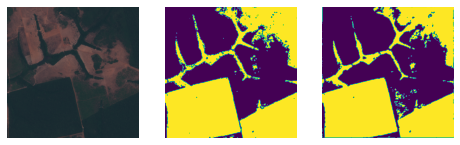

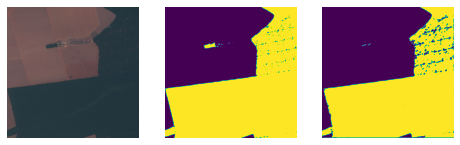

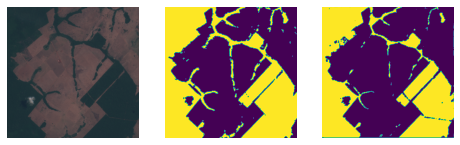

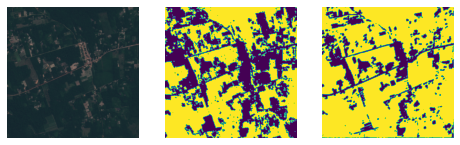

In [30]:
for i in range(15):
    # we show the image, the label, and the prediction - channel 1 - binarized using ">"
    show(Xval[i, :, :], Yval[i, :, :], Yhat_val[i, :, :, 1] > 0.5)

So, we see a pretty good match, using just a few layers and a few epochs.

However, it does look like this dataset is relatively easy: most of the forests are just green, and non-forest is not green!

## A much better model: U-Net Xception-style model

This model uses the U-net encoder-decoder architecture. Notice that it uses `layers.add([x, residual])` multiple times to put together values from earlier in the network (must be the same size as current layer, each time).

This model is much bigger and would require more data and more training to do well: we'll train for 10 epochs as in the simple model, and see that it's not performing well. Take a look at https://keras.io/examples/vision/oxford_pets_image_segmentation/, which uses a much larger and more difficult dataset - in that case, the large U-net is recommended over our simple model above.


This U-net model and the compile() and fit() calls are taken directly from https://keras.io/examples/vision/oxford_pets_image_segmentation/:

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/03/20<br>
**Last modified:** 2020/04/20<br>
**Description:** Image segmentation model trained from scratch on the Oxford Pets dataset.



In [32]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [37]:
unet_model = get_model(img_size, num_classes)
unet_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 256, 256, 32  896         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_27 (BatchN  (None, 256, 256, 32  128        ['conv2d_24[0][0]']              
 ormalization)                  )                                                           

In [38]:
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
unet_model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [39]:
epochs = 50
unet_model.fit(Xtrain, Ytrain, epochs=epochs, batch_size=6, validation_data=(Xval, Yval))

Epoch 1/50
5/5 [==============================] - 13s 622ms/step - loss: 6.4923 - accuracy: 0.6322 - val_loss: 0.9068 - val_accuracy: 0.5220
Epoch 2/50
5/5 [==============================] - 2s 351ms/step - loss: 1.8428 - accuracy: 0.7249 - val_loss: 0.7350 - val_accuracy: 0.3562
Epoch 3/50
5/5 [==============================] - 2s 339ms/step - loss: 0.5270 - accuracy: 0.8437 - val_loss: 0.8016 - val_accuracy: 0.5208
Epoch 4/50
5/5 [==============================] - 2s 364ms/step - loss: 0.6079 - accuracy: 0.7877 - val_loss: 0.8180 - val_accuracy: 0.4774
Epoch 5/50
5/5 [==============================] - 2s 338ms/step - loss: 0.3122 - accuracy: 0.8822 - val_loss: 0.7324 - val_accuracy: 0.4778
Epoch 6/50
5/5 [==============================] - 2s 352ms/step - loss: 0.3686 - accuracy: 0.8814 - val_loss: 0.8057 - val_accuracy: 0.4778
Epoch 7/50
5/5 [==============================] - 2s 338ms/step - loss: 0.4256 - accuracy: 0.8535 - val_loss: 0.8553 - val_accuracy: 0.4776
Epoch 8/50
5/5 [===

1/1 [==============================] - 1s 880ms/step


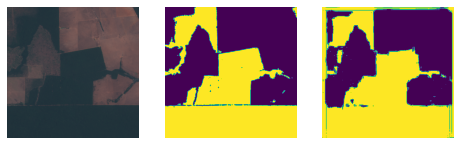

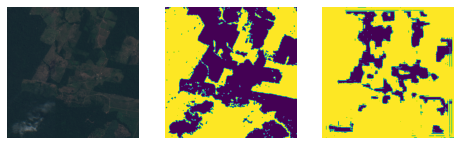

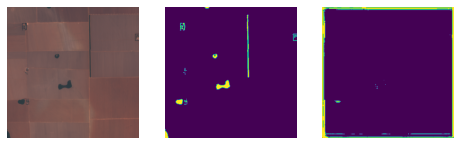

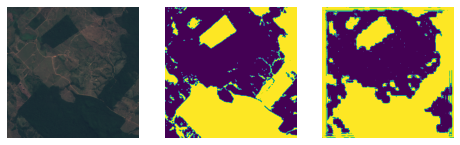

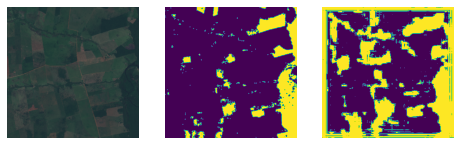

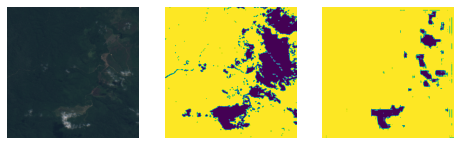

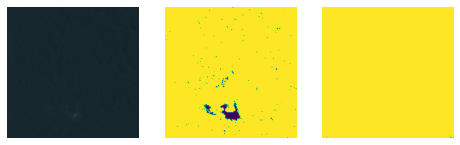

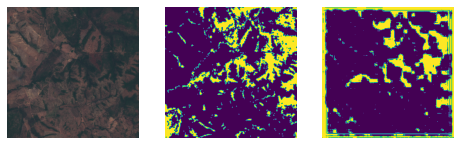

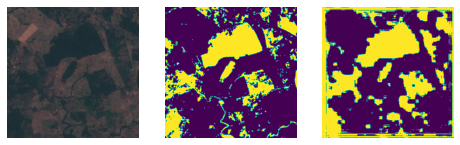

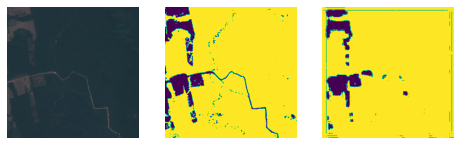

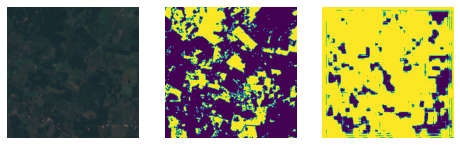

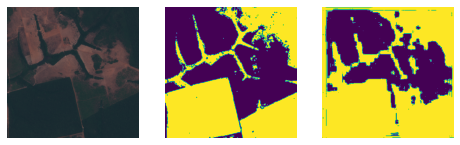

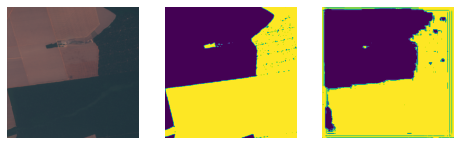

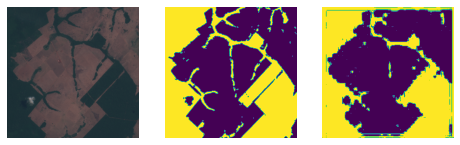

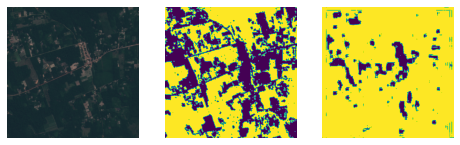

In [40]:
Yhat_val = unet_model.predict(Xval)
for i in range(15):
    show(Xval[i, :, :], Yval[i, :, :], Yhat_val[i, :, :, 1] > 0.5)

**Exercises**

1. What difference do you notice between the outputs of our simple model, and those of the sophisticated U-net? 
2. We looked at `Yhat_val[0, :, :, 1] > 0.5`. Try looking at channel 0 instead, and try different thresholds. Explain the results.
3. In our simple model, try some changes and observe the results: eg different dropout rates, different number of blocks, comment-out the BatchNorm, try different activations (but not for the final layer).
4. For our simple model, try running multiple times with the same hyperparameters. You'll probably see quite different performance in different runs.
5. In the U-net, notice we wrote `batch_size=6`. On Google Collab, I noticed an `OOM`, ie out-of-memory error, when trying to run the complete training set at once. That's because the GPU tries to allocate enough memory to store all the tensors at once.